# Train a Feature Extractor
Use an autoencoder or a simple neural network to learn a lower-dimensional representation of the MNIST data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Prepare dataset and dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop for autoencoder
def train_autoencoder():
    for epoch in range(num_epochs):
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.view(-1, 28*28))
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Train the autoencoder
train_autoencoder()

Epoch [1/10], Loss: 0.9336
Epoch [2/10], Loss: 0.9188
Epoch [3/10], Loss: 0.9298
Epoch [4/10], Loss: 0.9283
Epoch [5/10], Loss: 0.9232
Epoch [6/10], Loss: 0.9268
Epoch [7/10], Loss: 0.9239
Epoch [8/10], Loss: 0.9234
Epoch [9/10], Loss: 0.9225
Epoch [10/10], Loss: 0.9296


# Apply Unsupervised Techniques

* After training, we use the encoder part of the autoencoder to transform images into lower-dimensional feature vectors.

* We apply t-SNE to reduce the feature dimensions for visualization, and  apply K-means clustering


In [ ]:
# Extract features using the trained encoder
def extract_features():
    model.eval()
    features = []
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            encoded = model.encoder(data.view(-1, 28*28))
            features.append(encoded.cpu().numpy())
    return np.vstack(features)

# Extract features from the dataset
all_features = extract_features()

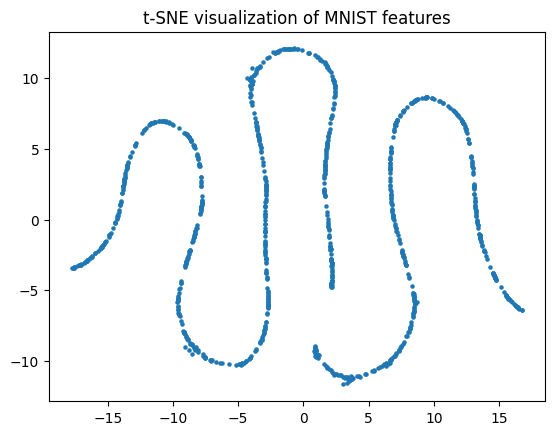

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


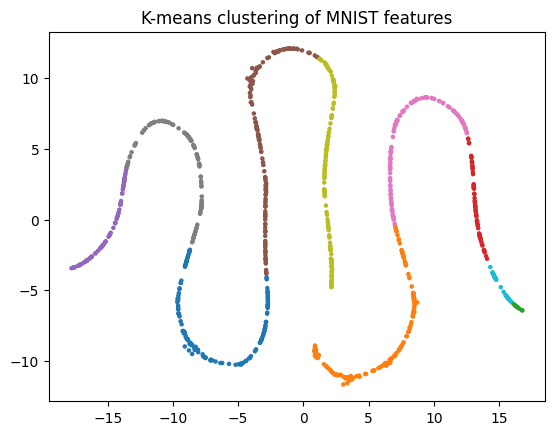

In [ ]:
#We keep only the first 1,000 features to reduce computation time.
features=all_features[:1000,:]


# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE results
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=5)
plt.title('t-SNE visualization of MNIST features')
plt.show()

# Apply K-means clustering
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(features)

# Plot K-means clustering results
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=clusters, cmap='tab10', s=5)
plt.title('K-means clustering of MNIST features')
plt.show()
